# Proyecto 04 - Informe Final de carrera - Redes Neuronales aplicadas a Procesamiento del Lenguaje Natural

## Resumen del proyecto

En este proyecto final de la carrera de **Data Science**, dicatada por **Acámica**, voy a profundizar en el Proyecto 3 - Procesamiento de Lenguaje Natural. 

En el proyecto anterior teniamos como objetivo implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. Se trata de un modelo de clasificación de multiclase. Los resultados no fueron muy convincentes, pero luego se tranformó en un modeo binario, donde ahí el accuracy obtenido fué muy prometedor (link de repocitorio https://github.com/SantiagoQuirogaG/Proyecto-3). 

El objetivo para este proyecto es mejorar el accuracy del modelo de clasificación binario obetenido.
Para eso propongo dos cambios:
* Primero una mejora en el Análisis Exploratorio de Datos (EDA): Analizando la lista de palabras que se encuentran en las stops words de la libreria SpaCy, descubro que al removerlas del data set estoy perdiendo informacion que puede ser de gran valor para la predicción de este modelo. Por eso decido retirarlas para luego ser utilizadas. 
* Segundo aplicar un modelo de Redes Neuronales, esto cumple con una de las consignas del proyecto de aplicar un modeo nuevo que no fue visto en clases. Además me llama mucho la atención la potencia y resultados que se obtienen con redes.



El proyecto estará dividido de la siguiente manera:

1°- **Análisis Exloratorio de Datos (EDA)**

2°- **Presentación del Modelo benchmark**

3°- **Red Neuronal**

4°- **Concluciones**

Link en GitHub: https://github.com/

### Descripción
El Dataset presenta una coleccion de criticas de usuarios de "Amazon". Cuenta con opiniones en español recolectadas entre noviembre de 2015 hasta noviembre de 2019. Cada comentario contiene: ID de critica, ID de producto, ID de usuario, cantidad de estrellas, descripción, título, lenguaje (en este caso todo es en español) y categoría del producto.

El Dataset esta dividido en 3 archivos, uno para entrenamiento, otro para testeo y el ultimo para validación.

In [1]:
import itertools
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk
nltk.download('punkt')
nltk.download('stopwords')
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
import re 
import string
from collections import Counter
from wordcloud import WordCloud 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\garga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\garga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Análisis Exploratorio de Datos

In [2]:
# Cargo los dataset
data_train = pd.read_json('../Proyecto 3/dataset_es_train.json', lines=True)
data_dev = pd.read_json('../Proyecto 3/dataset_es_dev.json', lines=True)
data_test = pd.read_json('../Proyecto 3/dataset_es_test.json', lines=True)

data_train.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes


In [3]:
print('Shape: ', data_train.shape)
print('Instancias: ', data_train.shape[0])
print('Columnas: ', data_train.columns)

Shape:  (200000, 8)
Instancias:  200000
Columnas:  Index(['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body',
       'review_title', 'language', 'product_category'],
      dtype='object')


In [4]:
# Cantidad de reviews según estrellas
data_train['stars'].value_counts()

5    40000
4    40000
3    40000
2    40000
1    40000
Name: stars, dtype: int64

In [5]:
# Controlo si todas las críticas estan en español
data_train['language'].value_counts()

es    200000
Name: language, dtype: int64

In [6]:
# ¿Hay datos faltantes?
data_train.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

In [7]:
# Dataset de testeo
print('Shape: ', data_dev.shape)
print('Instancias: ', data_dev.shape[0])
print('Columnas: ', data_dev.columns)

Shape:  (5000, 8)
Instancias:  5000
Columnas:  Index(['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body',
       'review_title', 'language', 'product_category'],
      dtype='object')


In [8]:
# ¿Hay datos faltantes?
data_dev.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

In [9]:
# Dataset de validación
print('Shape: ', data_test.shape)
print('Instancias: ', data_test.shape[0])
print('Columnas: ', data_test.columns)

Shape:  (5000, 8)
Instancias:  5000
Columnas:  Index(['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body',
       'review_title', 'language', 'product_category'],
      dtype='object')


In [10]:
# ¿Hay datos faltantes?
data_test.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

Ahora voy a transformar las 5 clases en sólo 2, Bueno y Malo. Se esta simplificando el modelo y le será mas facil predecir opiniones. A su vez las reviews con valores intermedios suelen ser muy subjetivas y hasta para el ser humano difíciles de identificar, ya que no hay mucha diferencia entre ellas.

La categoría Malo esta compuesto por críticas de 1, 2 y 3 estrellas.

La categoría Bueno esta compuesto por críticas de 4 y 5 estrellas.

In [11]:
diccionario = {1 : 'malo', 2 : 'malo', 3 : 'malo', 4 : 'bueno', 5 : 'bueno'}
data_train['binomial'] = data_train['stars'].map(diccionario)
data_dev['binomial'] = data_dev['stars'].map(diccionario)
data_test['binomial'] = data_test['stars'].map(diccionario)
data_train.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,binomial
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics,malo
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics,malo
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore,malo
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless,malo
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes,malo


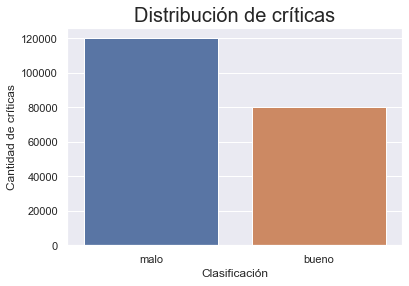

In [12]:
# Realizado este cambio, visualizo la distribución de las reviews
sns.countplot(x = "binomial", data = data_train)
plt.title('Distribución de críticas', fontsize=20)
plt.xlabel('Clasificación')
plt.ylabel('Cantidad de críticas')

plt.show()

Al convertir el problema de Machine Learning en un problema binario, los datasets han quedado desbalanciados, 60% de los casos son reviews negativos y 40% positivos. Este grado de desbalance no es alto, se puede trabajar sin problemas.

In [13]:
# ¿Cuántas categorías hay?
print('Cantidad de categorías:', len(data_train.product_category.unique()))

Cantidad de categorías: 30


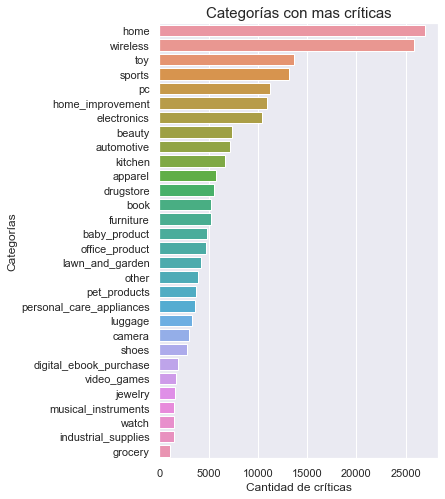

In [14]:
plt.figure(figsize = (5,8))
sns.countplot(data = data_train, y  = 'product_category', order = data_train['product_category'].value_counts().index)
plt.title('Categorías con mas críticas', fontsize=15)
plt.xlabel('Cantidad de críticas')
plt.ylabel('Categorías')
plt.show()

En el EDA realizado en el proyecto 3 se pudo determinar que las 3 categorías mejor puntuadas son Libros, Equipaje e Instrumentos Musicales, y las 3 categorías con menor puntaje son Ropa, Innalámbrico y Jardinería

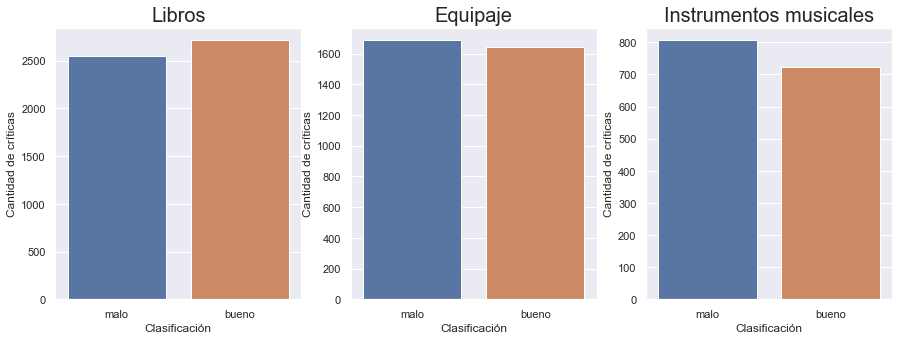

In [15]:
# Top 3 de mejores puntuaciones por categoría de producto
plt.figure(figsize=(15,5))

plt.subplot(131)
sns.countplot(x = "binomial", data = data_train[data_train['product_category']== 'book'])
plt.title('Libros', fontsize=20)
plt.xlabel('Clasificación')
plt.ylabel('Cantidad de críticas')


plt.subplot(132)
sns.countplot(x = "binomial", data = data_train[data_train['product_category']== 'luggage'])
plt.title('Equipaje', fontsize=20)
plt.xlabel('Clasificación')
plt.ylabel('Cantidad de críticas')


plt.subplot(133)
sns.countplot(x = "binomial", data = data_train[data_train['product_category']== 'musical_instruments'])
plt.title('Instrumentos musicales', fontsize=20)
plt.xlabel('Clasificación')
plt.ylabel('Cantidad de críticas')


plt.show()

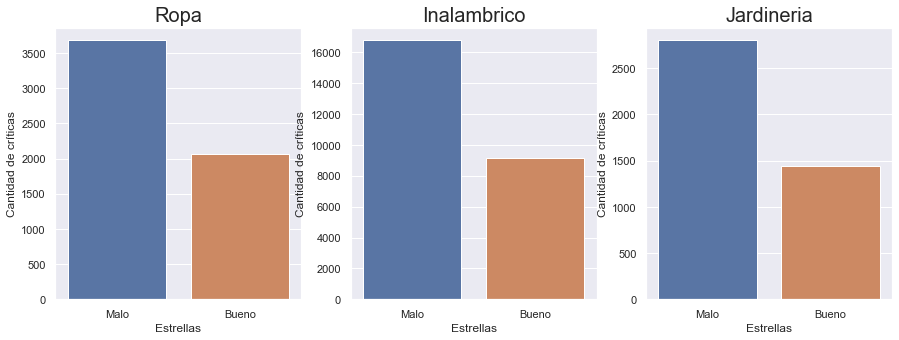

In [16]:
# Top 3 de peores puntuaciones por categoría de producto
plt.figure(figsize=(15,5))

plt.subplot(131)
sns.countplot(x = "binomial", data = data_train[data_train['product_category']== 'apparel'])
plt.title('Ropa', fontsize=20)
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de críticas')
plt.xticks([0, 1], ['Malo', 'Bueno'])

plt.subplot(132)
sns.countplot(x = "binomial", data = data_train[data_train['product_category']== 'wireless'])
plt.title('Inalambrico', fontsize=20)
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de críticas')
plt.xticks([0, 1], ['Malo', 'Bueno'])

plt.subplot(133)
sns.countplot(x = "binomial", data = data_train[data_train['product_category']== 'lawn_and_garden'])
plt.title('Jardineria', fontsize=20)
plt.xlabel('Estrellas')
plt.ylabel('Cantidad de críticas')
plt.xticks([0, 1], ['Malo', 'Bueno'])

plt.show()

In [17]:
# Creo una columna que reúna el título y el cuerpo de la crítica para un análisis más completo
data_train['review_full'] = data_train['review_title'] + ' ' + data_train['review_body']
data_dev['review_full'] = data_dev['review_title'] + ' ' + data_dev['review_body']
data_test['review_full'] = data_test['review_title'] + ' ' + data_test['review_body']
data_dev.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,binomial,review_full
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless,malo,"Mala compra Malisimo, muy grande demasiado apa..."
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel,malo,No lo he recibido No he recibido el pedido no ...
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports,malo,Que no aprieta bien en el manillar Tengo que b...
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement,malo,Brocas de mantequilla Utilicé las brocas de me...
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty,malo,No me gusta No me gusta su olor a viejo y aspe...


In [18]:
# Elimino las columnas que no son de interés
data_train1 = data_train.drop(columns=['language', 'review_id', 'product_id', 'reviewer_id', 'stars', 
                                       'review_body', 'review_title', 'product_category'])
data_dev1 = data_dev.drop(columns=['language', 'review_id', 'product_id', 'reviewer_id', 'stars', 
                                       'review_body', 'review_title', 'product_category'])
data_test1 = data_test.drop(columns=['language', 'review_id', 'product_id', 'reviewer_id', 'stars', 
                                       'review_body', 'review_title', 'product_category'])
data_train1.head()

,binomial,review_full
0,malo,television Nevir Nada bueno se me fue ka panta...
1,malo,Dinero tirado a la basura con esta compra Horr...
2,malo,solo llega una unidad cuando te obligan a comp...
3,malo,PRODUCTO NO RECIBIDO. No entro en descalificar...
4,malo,Devuelto Llega tarde y co la talla equivocada


Ahora se procede a limpiar el dataset, esta acción se denomina Normalización. La idea es eliminar información que no es valiosa para este caso, por ejemplo emojis, signos de puntuación, reemplazar mayusculas, eliminar palabras comunes (stopwords).

Por último se realiza la lemmatización la cual consiste llevar las palabras a su raiz, por ejemplo corriendo, corría y correría todas comparten las palabra raiz **correr**. De esta manera es más facil contabilizar las palabras aún cuando son escritas de forma distinta.

In [19]:
#Elimino los emojis de dataset TRAIN
data_train1['review_full'] = data_train1['review_full'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
data_dev1['review_full'] = data_dev1['review_full'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
data_test1['review_full'] = data_test1['review_full'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)

data_train1

,binomial,review_full
0,malo,television Nevir Nada bueno se me fue ka panta...
1,malo,Dinero tirado a la basura con esta compra Horr...
2,malo,solo llega una unidad cuando te obligan a comp...
3,malo,PRODUCTO NO RECIBIDO. No entro en descalificar...
4,malo,Devuelto Llega tarde y co la talla equivocada
...,...,...
199995,bueno,Tal y como se describe Mando funciona perfecta...
199996,bueno,Funciona perfectamente Compré la batería con c...
199997,bueno,Buena calidad. Buena calidad. Satisfecha con l...
199998,bueno,Recomendado Perfecto para el cumple de mi hijo


In [20]:
# Para generar un análisis se tiene que crear un objeto del modelo en español
nlp = spacy.load("es_core_news_lg")

In [21]:
stops = spacy.lang.es.stop_words.STOP_WORDS
#stops

Defino y utilizo una función llamada "normal" la cual elimina stopwords, signos de puntuación y lleva a cabo la lemmatización.

Analizando la lista de palabras por defecto de stopwords, se pueden observar palabras que pueden estar muy relacionadas con la opinión de un usuario respecto a su producto, por eso se decide quitar algunas de estas.

In [22]:
#Función que elimina stopwords, signos de puntuación y lleva a cabo la lemmatización.

def normal(comment, lowercase, remove_stopwords):
    
    punctuations = string.punctuation
    stops = spacy.lang.es.stop_words.STOP_WORDS
    non_stops = ['no', 'si', 'sí', 'bien','buen','bueno','buenos','buena','buenas','peor', 'bajo', 'mal', 'mejor','nada']
    otros = ['y', 'e', 'a', 'o', 'para', 'pare', 'paro', 'como', 'q','..','...','....', '.....','.......', '...........',
             '¡','¿']

    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        if word.text not in non_stops:
            if not remove_stopwords or (remove_stopwords and word.text not in stops): 
                if word.text not in punctuations:
                    if word.text not in otros:
                        lemma = word.lemma_.strip()
                        lemmatized.append(lemma)
        elif word.text in non_stops:
            lemma = word.lemma_.strip()
            lemmatized.append(lemma)
            
    return " ".join(lemmatized)

In [23]:
# Aplico la función normal para TRAIN y creo la columna review_clean
#data_train1['review_normal'] = data_train1['review_full'].apply(normal, lowercase=True, remove_stopwords=True)
#data_train1

In [24]:
# Para no tener que esperar la ejecucion de la celda anterior,
# guardo el dataset obtenido en el equipo y luego lo llamo para seguir trabajando.
#data_train1.to_csv('DS_Proyecto_04_data_train_normal.csv', index = False, encoding = 'utf-8')

In [25]:
data_train1 = pd.read_csv('DS_Proyecto_04_data_train_normal.csv')
data_train1['review_normal'] = data_train1['review_normal'].apply(str)
data_train1.head()

,binomial,review_full,review_normal
0,malo,television Nevir Nada bueno se me fue ka panta...,television nevir nadar bueno ka pantalla 8 mes...
1,malo,Dinero tirado a la basura con esta compra Horr...,dinero tirar basura comprar horrible tener com...
2,malo,solo llega una unidad cuando te obligan a comp...,llegar unidad obligar comprar obligar comprar ...
3,malo,PRODUCTO NO RECIBIDO. No entro en descalificar...,producto no recibir no entrar descalificar ven...
4,malo,Devuelto Llega tarde y co la talla equivocada,devolver llegar co tallar equivocar


In [26]:
# Aplico la función normal para DEV y creo la columna review_clean
#data_dev1['review_normal'] = data_dev1['review_full'].apply(normal, lowercase=True, remove_stopwords=True)
#data_dev1.to_csv('DS_Proyecto_04_data_dev_normal.csv', index = False, encoding = 'utf-8')

In [27]:
# Aplico la función normal para TEST y creo la columna review_clean
#data_test1['review_normal'] = data_test1['review_full'].apply(normal, lowercase=True, remove_stopwords=True)
#data_test1.to_csv('DS_Proyecto_04_data_test_normal.csv', index = False, encoding = 'utf-8')

In [28]:
data_test1 = pd.read_csv('DS_Proyecto_04_data_test_normal.csv')
data_test1['review_normal'] = data_test1['review_normal'].apply(str)
data_test1.head()

,binomial,review_full,review_normal
0,malo,no me llego no me llego el articulo me lo mand...,no llegar no llegar articular mandar correo no...
1,malo,amazon sigue sin cumplir en las entregas la me...,amazon cumplir entregar mensajería horrible no...
2,malo,ESTAFA EN EL ENVÍO Estoy muy decepcionado con ...,estafar enviar decepcionar vendedor pedir no n...
3,malo,Estafa de Amazon Mi valoración no es sobre el ...,estafar amazon valoración no producto amazon o...
4,malo,No conseguí pasar de la portada en Kindle Pues...,no conseguir pasar portar kindle interés libra...


In [29]:
data_dev1 = pd.read_csv('DS_Proyecto_04_data_dev_normal.csv')
data_dev1['review_normal'] = data_dev1['review_normal'].apply(str)
data_dev1.head()

,binomial,review_full,review_normal
0,malo,"Mala compra Malisimo, muy grande demasiado apa...",malo comprar malisimo grande aparatoso mal pro...
1,malo,No lo he recibido No he recibido el pedido no ...,no recibir no recibir pedir no devolución
2,malo,Que no aprieta bien en el manillar Tengo que b...,no apretar bien manillar buscar sistema no fun...
3,malo,Brocas de mantequilla Utilicé las brocas de me...,broca mantequilla utilizar broca menor diámetr...
4,malo,No me gusta No me gusta su olor a viejo y aspe...,no gustar no gustar olor viejo aspecto malo


In [30]:
# ¿Hay datos faltantes?
print(data_train1.isna().sum())
print(data_dev1.isna().sum())
print(data_test1.isna().sum())

binomial         0
review_full      0
review_normal    0
dtype: int64
binomial         0
review_full      0
review_normal    0
dtype: int64
binomial         0
review_full      0
review_normal    0
dtype: int64


In [31]:
# Divido el dataset por sus calificaciones y analiso
df_malo = data_train1[data_train1.binomial == 'malo']
df_bueno = data_train1[data_train1.binomial == 'bueno']

In [32]:
# Shape de las críticas malas
df_malo.shape

(120000, 3)

In [33]:
r_malo = []
for i in range(df_malo.shape[0]):
    titular = df_malo.iloc[i].review_normal #seleccionar el titular
    titular = nltk.RegexpTokenizer('\w+').tokenize(titular) # Tokenizar 
    titular = [t for t in titular if len(t)>1] # elimino las palabras que tengan una letra
    r_malo.append(titular) #agregar el resultado a la lista
    
r_malo = list(itertools.chain(*r_malo))

word_freq = Counter(r_malo)
common_words_malo = word_freq.most_common()

print('Lista de palabras más comunes para críticas negativas')
df_r_malo = pd.DataFrame(common_words_malo, columns = ['Words', 'Frequency'])
df_r_malo.head(15)

Lista de palabras más comunes para críticas negativas


,Words,Frequency
0,no,152982
1,bien,33894
2,calidad,24149
3,comprar,20888
4,producto,20663
5,bueno,20393
6,si,18704
7,funcionar,17237
8,llegar,16450
9,nadar,15570


In [34]:
# Shape de las críticas buenas
df_bueno.shape

(80000, 3)

In [35]:
r_bueno = []
for i in range(df_bueno.shape[0]):
    titular = df_bueno.iloc[i].review_normal #seleccionar el titular
    titular = nltk.RegexpTokenizer('\w+').tokenize(titular) # Tokenizar 
    titular = [t for t in titular if len(t)>1] # elimino las palabras que tengan una letra
    r_bueno.append(titular) #agregar el resultado a la lista
    
r_bueno = list(itertools.chain(*r_bueno))

word_freq = Counter(r_bueno)
common_words_bueno = word_freq.most_common()

print('Lista de palabras más comunes para críticas positivas')
df_r_bueno = pd.DataFrame(common_words_bueno, columns = ['Words', 'Frequency'])
df_r_bueno.head(15)

Lista de palabras más comunes para críticas positivas


,Words,Frequency
0,bueno,42984
1,no,32835
2,bien,29554
3,calidad,23521
4,preciar,16987
5,perfecto,16141
6,comprar,14853
7,producto,12958
8,cumplir,7734
9,gustar,7692


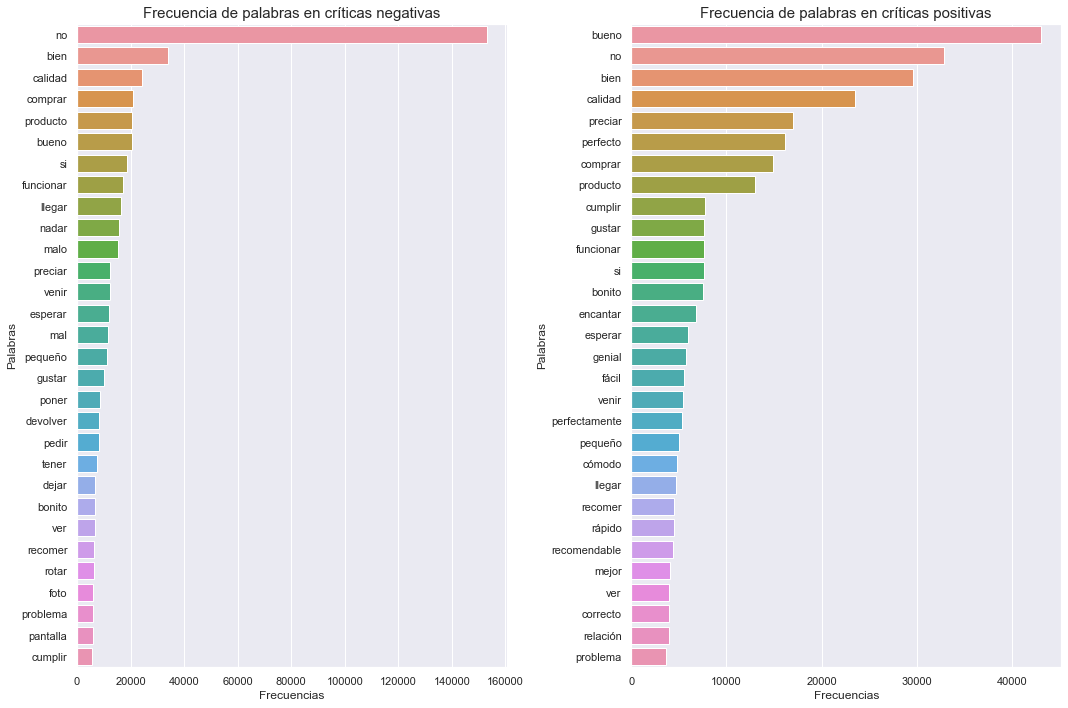

In [36]:
plt.figure(figsize = (15,10))

plt.subplot(121)
plot = sns.barplot(y  = df_r_malo.iloc[:30].Words, x = df_r_malo.iloc[:30].Frequency)
plt.title('Frecuencia de palabras en críticas negativas', fontsize=15)
plt.xlabel('Frecuencias')
plt.ylabel('Palabras')

plt.subplot(122)
plot = sns.barplot(y  = df_r_bueno.iloc[:30].Words, x = df_r_bueno.iloc[:30].Frequency)
plt.title('Frecuencia de palabras en críticas positivas', fontsize=15)
plt.xlabel('Frecuencias')
plt.ylabel('Palabras')

plt.tight_layout()
plt.show()

Hay una gran diferencia en cuanto a la palabra con mayor frecuencia, en críticas negativas la palabra "no" se repite casi 160000 veces. En cambio cuando la crítica es positiba la palabra bueno se repito mas de 40000 veces.

Si tenemos en cuenta la cantidad de malas reviews (120000) podemos concluir que siempre esta presente la palabra "no" en cada una de ellas.

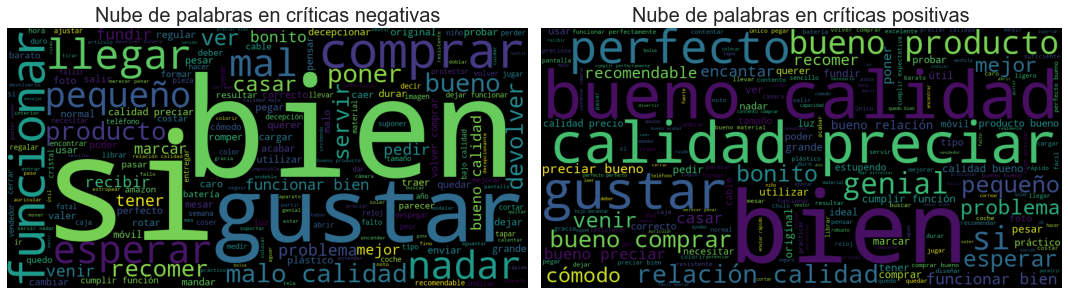

In [37]:
plt.figure(figsize=(15,15))

plt.subplot(121)
unique_string=(" ").join(r_malo)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Nube de palabras en críticas negativas', fontsize=20)

plt.subplot(122)
unique_string=(" ").join(r_bueno)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Nube de palabras en críticas positivas', fontsize=20)

plt.tight_layout()
plt.show()

En la nube de palabra el tamaño de cada palabra indica su frecuencia o importancia en las críticas. A simple vista se aprecia la diferencia entre ambas.

# Modelo Benchmark - Linear SVC

Como se mencionó anteriormente el modelo benchmark es el modelo binario optimizado obtenido en el proyecto 3 (Link para acceder al proyecto 3 en GitHub: https://github.com/SantiagoQuirogaG/Proyecto-3). 

Los resultados expuestos a continuación fueron los obtenidos del modelo validado con el dataset TEST:

A continuación, copiaré los parámetros usados en el modelo, el accuracy del modelo y la matriz de confusión obtenida.

Para generar el modelo:

El vectorizado se realizó usando el TfidfVectorizer, con los siguientes parámetros:
* ngram_range = (1,2)
* min_df = 30
* max_features = 1000
* los demás parámetros por defecto

El modelo fue un Linear SVC, con los siguientes parámetros:
* dual = False
* random_state = 42
* penalty = 'l1'
* C = 2
* loss = 'squared_hinge'
* tol = 0.01
* multi_class='ovr'
* los demás parámetros por defecto

Accuracy y matriz de confusión

* Train Accuracy:  **0.81886**

* Test Accuracy:  **0.8186**

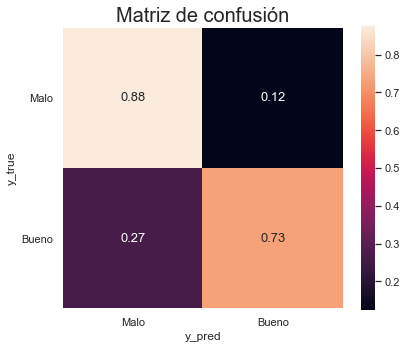

El modelo predice de manera correcta un 88% de la etiqueta **negativa** y un 73% de la etiqueta **positiva** en el Test.

# Red Neuronal

Una de las mejoras ya fue realizada, mejora en el Análisis Exploratorio de Datos (EDA). Se eliminaron de la lista de sotpwords aquellas palabras que si aportan información al modelo, y varias de ellas aparece en la lista de palabras más comunes.

A continuación desarrollaré la segunda mejora, un modelo de Red Neuronal.

In [38]:
import random
from numpy.random import seed

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dropout
from keras.utils import plot_model
from plot_keras_history import plot_history
from keras.regularizers import l2

import sklearn.model_selection
import sklearn.preprocessing

Using TensorFlow backend.


In [39]:
data_train2 = data_train1.copy()
data_dev2 = data_dev1.copy()
data_test2 = data_test1.copy()

data_train2.head()

,binomial,review_full,review_normal
0,malo,television Nevir Nada bueno se me fue ka panta...,television nevir nadar bueno ka pantalla 8 mes...
1,malo,Dinero tirado a la basura con esta compra Horr...,dinero tirar basura comprar horrible tener com...
2,malo,solo llega una unidad cuando te obligan a comp...,llegar unidad obligar comprar obligar comprar ...
3,malo,PRODUCTO NO RECIBIDO. No entro en descalificar...,producto no recibir no entrar descalificar ven...
4,malo,Devuelto Llega tarde y co la talla equivocada,devolver llegar co tallar equivocar


La métrica elegida para evaluar los modelos fue la exactitud (accuracy). La elegí debido a que es un problema de clasificación, aunque las clases esten ligeremante desbalanceadas no es un plroblema. Además, no interesa alguna clase en particular, sino el rendimiento general del modelo.

* Encodeado de etiquetas

¿Por qué encodear las etiquetas? Esto será utilizado para el modelo de Redes Neuronales. Ya que defino dos nodos de salida, es necesario dividir la columna labelen label_bueno label_malo.

In [40]:
#Aplico get_dummies para TRAIN
data_train2 = pd.concat([data_train2, pd.get_dummies(data_train2['binomial'],
                                                     prefix='label',
                                                     prefix_sep = '_')],
                                                     axis=1)
data_train2

,binomial,review_full,review_normal,label_bueno,label_malo
0,malo,television Nevir Nada bueno se me fue ka panta...,television nevir nadar bueno ka pantalla 8 mes...,0,1
1,malo,Dinero tirado a la basura con esta compra Horr...,dinero tirar basura comprar horrible tener com...,0,1
2,malo,solo llega una unidad cuando te obligan a comp...,llegar unidad obligar comprar obligar comprar ...,0,1
3,malo,PRODUCTO NO RECIBIDO. No entro en descalificar...,producto no recibir no entrar descalificar ven...,0,1
4,malo,Devuelto Llega tarde y co la talla equivocada,devolver llegar co tallar equivocar,0,1
...,...,...,...,...,...
199995,bueno,Tal y como se describe Mando funciona perfecta...,describir mandar funcionar perfectamente cumpl...,1,0
199996,bueno,Funciona perfectamente Compré la batería con c...,funcionar perfectamente comprar batería retice...,1,0
199997,bueno,Buena calidad. Buena calidad. Satisfecha con l...,bueno calidad bueno calidad satisfacer comprar,1,0
199998,bueno,Recomendado Perfecto para el cumple de mi hijo,recomendar perfecto cumplir hijo,1,0


In [41]:
#Aplico get_dummies para DEV y TEST
data_dev2 = pd.concat([data_dev2, pd.get_dummies(data_dev2['binomial'],
                                                     prefix='label',
                                                     prefix_sep = '_')],
                                                     axis=1)

data_test2 = pd.concat([data_test2, pd.get_dummies(data_test2['binomial'],
                                                     prefix='label',
                                                     prefix_sep = '_')],
                                                     axis=1)

In [42]:
# Tomamos la lista de palabras y el vector que nos dice la calificación tanto para train, dev y test
list_review_train = list(data_train2['review_normal'].values)
calif_train = data_train2.iloc[:, [3,4]]

list_review_dev = list(data_dev2['review_normal'].values)
calif_dev = data_dev2.iloc[:, [3,4]]

list_review_test = list(data_test2['review_normal'].values)
calif_test = data_test2.iloc[:, [3,4]]

# Preparamos el conversor de bag of words a vectores que traemos de sklearn.
# Debido a la capacidad de memoria disponible usaremos solo las 3000 palabras con mas frecuencia en todo el corpus 
# para generar los vectores
vectorizer = TfidfVectorizer(max_features=3000, min_df=30, ngram_range=(1, 2))
# generarnos los vectores para cada review a partir del corpus total.
matriz_review_train = vectorizer.fit_transform(list_review_train)
matriz_review_dev = vectorizer.transform(list_review_dev)
matriz_review_test = vectorizer.transform(list_review_test)

# Visualisamos el shape 
print(matriz_review_train.shape)
print(matriz_review_dev.shape)
print(matriz_review_test.shape)

(200000, 3000)
(5000, 3000)
(5000, 3000)


In [43]:
# Cambio los tipos de datos de las matrices para mayor agilidad
matriz_review_train = matriz_review_train.astype('float32')

matriz_review_dev = matriz_review_dev.astype('float32')

matriz_review_test = matriz_review_test.astype('float32')

In [44]:
# Defino x_train e y_train a partir del dataset TRAIN
x_train = matriz_review_train.toarray()
y_train = calif_train

# Defino x_dev e y_dev a partir del dataset DEV
x_dev = matriz_review_dev.toarray()
y_dev = calif_dev

# Defino x_test e y_test a partir del dataset TEST
x_test = matriz_review_test.toarray()
y_test = calif_test

Las **redes neuronales** artificiales son un modelo inspirado en el funcionamiento del cerebro humano. Esta formado por un conjunto de nodos conocidos como neuronas artificiales que están conectadas y transmiten señales entre sí. Estas señales se transmiten desde la entrada hasta generar una salida. 

Fuente: https://www.atriainnovation.com/que-son-las-redes-neuronales-y-sus-funciones/

Anteriormente los datos ya fueron cargados y procesados, ahora se determian una semilla para obtener los mismos resultados.

In [45]:
#Determino una semilla para poder replicar los mismos resultados
my_seed = 100

seed(my_seed)
tf.random.set_seed(my_seed)

Los modelos en Keras son definidos como una sequencias de capas. Podemos crear un modelo sequencia (Sequencial) y agregar capas una a una hasta que cumplan nuestros requerimientos.

El primer paso es asegurarnos que la primer capa tenga el numero correcto de entradas. Estos puede ser espcificado con el argumento input_dim, en este caso utilizaremos el valor de 3000, que es el shape de la matriz de entrenamiento (x_tarin).

¿Cómo saber el numero de capas y sus tipos? Esta es una pregunta complicada pero normalmente se experimenta y a prueba y error se puede llegar a un resultado óptimo. En este caso vamos a utilizar una red conectada completamente con 6 capas.

Fuente: https://medium.com/@gogasca_/tu-primer-red-neuronal-usando-keras-72d36130ee6c.

Las funciones de activación uilizadas seran ReLU y Sigmoid, según la documentación ReLU es la más rapida en el entrenamiento, mientras que Sigmoid es más compleja. Es por eso que es recomendable usar ReLU en las capas ocultas y en la última capa utilizar Sigmoid.

Para modelos de clasificación binaria es recomendable utilizar "binary crossentropy" como función de pérdida, al igual que el otimizador "sgd" que es recomendado en la documentación.

El número de épocas y tamaño de lote (batch) se determinó manualmente y analizando sus resultados.

Según datos empíricos al usar la regulización "Dropout" para problemas de NLP, puede suceder que se eliminen palábras muy importantes para la clasificación del modelo, por esto apliqué el factor de regularización L2 (Ridge) 

In [46]:
#Determino el input
input_dim = x_train.shape[1]
print(input_dim)

3000


In [47]:
# Defino el modelo de red neuronal
model = Sequential()
model.add(layers.Dense(3000, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(2000, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.001)))
model.add(layers.Dense(1000, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.001)))
model.add(layers.Dense(100, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.001)))
model.add(layers.Dense(10, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.001)))
model.add(layers.Dense(2, activation='sigmoid'))

Una vez que el modelo esta definido, se procede a compilarlo. Al compilar el modelo se mandan llamar las librerias en el backend, en nuestro caso Tensorflow. En este caso el backend automáticamente selecciona la mejor forma de representar la red neuronal para entrenamiento y realizar predicciones en el hardware. Cuando se compila el modelo, se deben definir algunas propiedades adicionales requeridas para el entrenamiento del modelo:

* La función de perdida o loss function, que es utilizada para evaluar los pesos. 
* El optimizador utilizado para buscar entre los pesos de la red 
* Las métricas opcionales que se require para colectar y reportar durante el entrenamiento. Al ser un problema de clasificación binaria, se coleccionará y reportará la precision de la clasificación utilizando accuracy.

Fuente: https://medium.com/@gogasca_/tu-primer-red-neuronal-usando-keras-72d36130ee6c

In [48]:
# Compilar modelo
model.compile(loss='binary_crossentropy', 
              optimizer= 'sgd', 
              metrics=['accuracy'])

In [49]:
# Resumen del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3000)              9003000   
_________________________________________________________________
dense_2 (Dense)              (None, 2000)              6002000   
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dense_4 (Dense)              (None, 100)               100100    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 22        
Total params: 17,107,132
Trainable params: 17,107,132
Non-trainable params: 0
__________________________________________

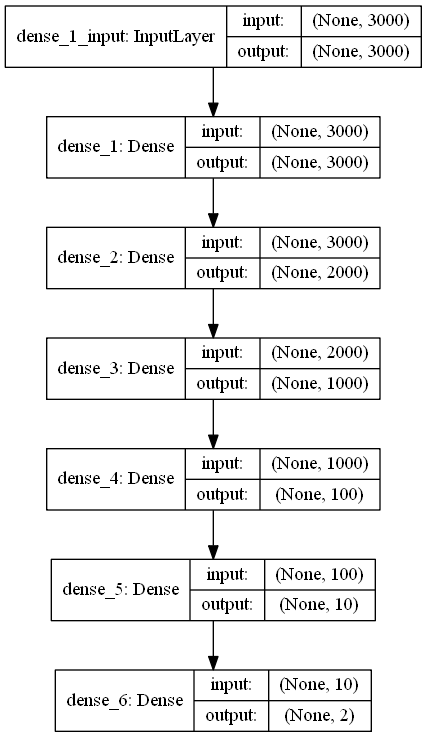

In [50]:
# Visualización del modelo
plot_model(model, show_shapes = True)

Una vez que está definido y compilado el modelo, es tiempo de ejecutar el modelo con los datos. EL modelo se entrena llamando la función fit().

El proceso de entrenamiento se ejecuta cierto numero de veces utilizando el dataset, este numero de veces es llamado epochs, y se define utilizando el parámetro "epochs". También podemos definir el numero de instances que son evaluadas antes de que los pesos sean actualizados en la red neuronal. Este parámetro se llama "batch_size".

In [51]:
# Entrenar el modelo
history = model.fit(x_train, y_train,
                    epochs=30,
                    validation_data=(x_dev, y_dev),
                    batch_size=100).history

Train on 200000 samples, validate on 5000 samples
Epoch 1/30
200000/200000 [==============================] - 507s 3ms/step - loss: 4.4588 - accuracy: 0.5995 - val_loss: 4.3058 - val_accuracy: 0.6000
Epoch 2/30
200000/200000 [==============================] - 471s 2ms/step - loss: 4.1637 - accuracy: 0.6000 - val_loss: 4.0252 - val_accuracy: 0.6000
Epoch 3/30
200000/200000 [==============================] - 501s 3ms/step - loss: 3.8929 - accuracy: 0.6000 - val_loss: 3.7632 - val_accuracy: 0.6000
Epoch 4/30
200000/200000 [==============================] - 502s 3ms/step - loss: 3.6268 - accuracy: 0.6037 - val_loss: 3.4670 - val_accuracy: 0.6434
Epoch 5/30
200000/200000 [==============================] - 494s 2ms/step - loss: 3.1956 - accuracy: 0.7997 - val_loss: 3.0063 - val_accuracy: 0.8553
Epoch 6/30
200000/200000 [==============================] - 528s 3ms/step - loss: 2.8881 - accuracy: 0.8552 - val_loss: 2.7794 - val_accuracy: 0.8648
Epoch 7/30
200000/200000 [========================

In [53]:
#Calculo el accuracy y la pérdida para Train, Dev y Test
train_scores = model.evaluate(x_train, y_train, verbose=0)
print("Train loss:", train_scores[0])
print("Train accuracy:", train_scores[1],'\n')

dev_scores = model.evaluate(x_dev, y_dev, verbose=0)
print("Dev loss:", dev_scores[0])
print("Dev accuracy:", dev_scores[1], '\n')

test_scores = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1], '<--')

Train loss: 0.6395338913679123
Train accuracy: 0.8932750225067139 

Dev loss: 0.7005457962989807
Dev accuracy: 0.8694999814033508 

Test loss: 0.6910157608032227
Test accuracy: 0.8604000210762024 <--


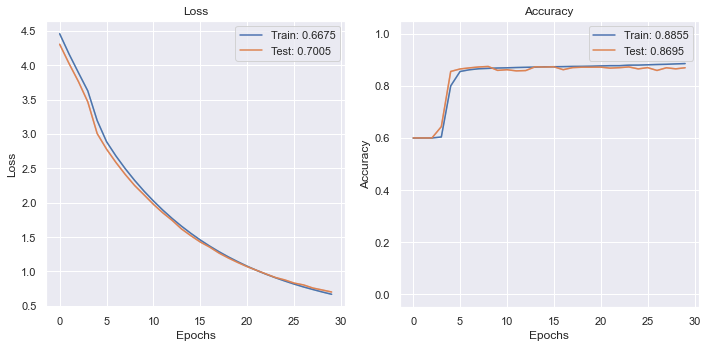

In [54]:
#Grafico la pérdida y la exactitud de acuerdo a las épocas
plot_history(history)
plt.show()

Analizando los gárficos obtenidos se puede observar que la pérdida en Train y Test (dev) disminuye a medida que pasan las épocas y comienza a ser mas regular luedo de las 25 épocas. 

En el caso de accuracy se puede ver como, luego de las 5 épocas se estabiliza, y pasando las 25 se puede notar un leve overfitting, por lo que 30 épocas es un buen valor para este modelo.

Ahora procedo a evaluar el modelo.

In [55]:
# Vuelvo a definir y_dev para poder evaluar
# 1 = malo y 0 = bueno
y_dev =  data_dev2.iloc[:, [4]]
y_dev

,label_malo
0,1
1,1
2,1
3,1
4,1
...,...
4995,0
4996,0
4997,0
4998,0


In [56]:
# Predicciones 
y_pred_dev = model.predict_classes(x_dev)

In [57]:
y_pred_dev

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

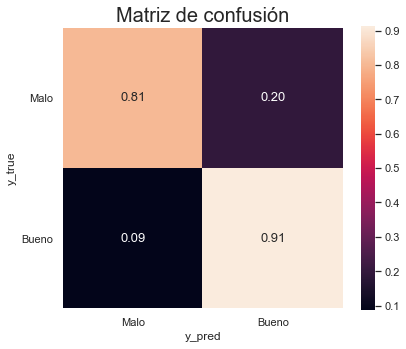

In [58]:
plt.figure(figsize=(6, 5))
conf_sent = confusion_matrix(y_dev, y_pred_dev, 
                             labels=[0, 1], 
                             normalize='true')
sns.heatmap(data = conf_sent, cbar=True, square=True, annot=True, 
            fmt= '.2f', annot_kws={'size': 13}, 
            xticklabels= ['Malo', 'Bueno'], 
            yticklabels=['Malo', 'Bueno'])

plt.title('Matriz de confusión', fontsize=20)
plt.ylabel('y_true')
plt.xlabel('y_pred')
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

Como conclusión el modelo de redes neuronales tiene un accuracy para el entrenamiento de 0.8933 y para Test de 0.8695. Predice de manera correcta el 81% de las críticas malas y un 91% de las críticas buenas en el entrenamiento.

#### Validación
Valido el modelo con el dataset test

In [59]:
# Vuelvo a calcular el accuracy y la pérdida para Test
test_scores = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Test loss: 0.6910157608032227
Test accuracy: 0.8604000210762024


In [60]:
# Predicciones 
y_pred_test = model.predict_classes(x_test)

In [61]:
y_pred_test

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [62]:
# Vuelvo a definir y_test para evaluar
# 1 = malo y 0 = bueno
y_test =  data_test2.iloc[:, [4]]
y_test

,label_malo
0,1
1,1
2,1
3,1
4,1
...,...
4995,0
4996,0
4997,0
4998,0


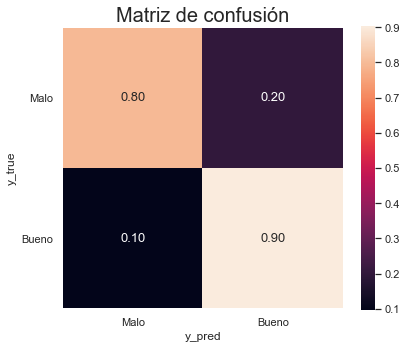

In [63]:
plt.figure(figsize=(6, 5))
conf_sent = confusion_matrix(y_test, y_pred_test, 
                             labels=[0, 1], 
                             normalize='true')
sns.heatmap(data = conf_sent, cbar=True, square=True, annot=True, 
            fmt= '.2f', annot_kws={'size': 13}, 
            xticklabels= ['Malo', 'Bueno'], 
            yticklabels=['Malo', 'Bueno'])

plt.title('Matriz de confusión', fontsize=20)
plt.ylabel('y_true')
plt.xlabel('y_pred')
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

Como conclusión final se observa que el modelo tiene un accuracy alto (0,86), teniendo mayor efectividad a la hora de predecir criticas buenas (90%), pero tambien siendo bueno para predecir las críticas malas (80%).

### Linear SVC vs Red Neuronal

En el modelo de red neuronal arrojó los siguientes resultados:

* Train accuracy: **0.8933** 
* Test accuracy:  **0.8604**

En el modelo de Linear SVC arrojó los siguientes resultados:

* Train accuracy: **0.8189**
* Test accuracy:  **0.8186**

Se observa una mejora en el "Train Accuracy" y también en el "Test Accuracy", en menor medida, para el modelo de red neuronal. En mi opinión no es muy significativo el aumento.

![Comparativa](vs.png "Comparativa")

Analizando la matriz de confusión de cada modelo se identifica que la red neuronal es mejor clasificando críticas positivas y el modelo benchmark tiene mayor facilidad para identificar críticas negativas.

Esta variación en los modelos esta dada por el cambio que se realizó en el EDA (analisis exploratorio de datos), ya que la lista de palabras más comunes es diferente para cada caos a la que se tenia en el modeo anterior.

En mi opinion ambos modelos tienen resultados similares, se puede apreciar que la red neuronal tiene resultados más balanceados a la hora de clasisficar que el modelo benchmark, pero posee un leve overfitting que en el modelo anterior es mínimo. A su vez el tiempo que lleva entrenar la red es muchísimo mayor que el que se emplea para obtener el modelo de Linear SVC, sindo este un recurso muy valioso.

Cabe destacar que la Red Neuronal tiene una estructura sencilla, se podría desarrollar un modelo mas complejo y quizás obtener mejores resultados, como es así con el modelo Linear SVC.

Como recomendación, para este caso, propongo optimizar el pre procesamiento de datos y el modelo del proyecto anterior (Linear SVC), que es probable obtener mejores resultados con menos tiempo de entrenamiento y recursos de PC.

Saludos.